In [9]:
import numpy as np
import matplotlib.pyplot as plt

from mytorch.nn.activation import ReLU, Sigmoid, Tanh, LinearActivation
from mytorch.nn.initialization import Xavier, He
from mytorch.nn.linear import Linear
from mytorch.nn.loss import CrossEntropyLoss, L2Loss
from mytorch.optim.optimizer import SGD, Adam
from models.mlp import MLP
import numpyNN

In [10]:
# based on dataset.py from IML HW 6 
def one_hot_encoding(y, num_classes=2):
    one_hot = np.eye(num_classes)[y.astype(int).flatten()]
    return one_hot

In [11]:
def train_and_test_mlp(mlp, x_train, y_train, x_test, y_test, opt_loss, opt_optim, num_epoch=20, batch_size=32):
    assert x_train.shape[0] == y_train.shape[0], "x_train and y_train must have the same length"
    assert x_test.shape[0] == y_test.shape[0], "x_test and y_test must have the same length"

    train_loss, train_accuracy = [], []
    test_loss, test_accuracy = [], []

    y_train_encoded = one_hot_encoding(y_train)  
    y_test_encoded = one_hot_encoding(y_test)

    for epoch in range(num_epoch):
        # Shuffle training data and labels
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train_encoded[indices]

        batch_losses = []
        batch_accuracies = []

        # mini-batches
        for start_idx in range(0, x_train.shape[0], batch_size):
            end_idx = min(start_idx + batch_size, x_train.shape[0])
            batch_x = x_train_shuffled[start_idx:end_idx]
            batch_y = y_train_shuffled[start_idx:end_idx]

            y_pred_train = mlp.forward(batch_x)
            loss_train = opt_loss.forward(y_pred_train, batch_y)
            batch_losses.append(np.mean(loss_train))

            dLdZ = opt_loss.backward()  # Use correct call for backward computation
            mlp.backward(dLdZ)
            opt_optim.step()
            opt_optim.zero_grad()

            predicted_labels_train = np.argmax(y_pred_train, axis=1)
            true_labels_train = np.argmax(batch_y, axis=1)
            accuracy_train = np.sum(predicted_labels_train == true_labels_train) / len(batch_x)
            batch_accuracies.append(accuracy_train)

        # Compute mean loss and accuracy for the epoch
        epoch_loss = np.mean(batch_losses)
        epoch_accuracy = np.mean(batch_accuracies)
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)

        # Testing (evaluate the model with the current state on the test set)
        mlp_eval = mlp.copy()  # Ensure your MLP class has a proper copy method
        y_pred_test = mlp_eval.forward(x_test)
        loss_test = opt_loss.forward(y_pred_test, y_test_encoded)
        test_loss.append(np.mean(loss_test))

        predicted_labels_test = np.argmax(y_pred_test, axis=1)
        true_labels_test = np.argmax(y_test_encoded, axis=1)
        accuracy_test = np.sum(predicted_labels_test == true_labels_test) / len(x_test)
        test_accuracy.append(accuracy_test)

        print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}, Test Loss: {np.mean(loss_test)}, Test Accuracy: {accuracy_test}")

    logs = {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }
    return logs

In [174]:
def plot_3d (x_train_augmented, y_train, feature, savefig=False, name= None):
    # Splitting x_train_augmented into separate features for easier handling
    feature_1 = x_train_augmented[:, 0]
    feature_2 = x_train_augmented[:, 1]
    feature_3 = x_train_augmented[:, 2]

    # Separating data points based on y_train values
    class_0_indices = (y_train.flatten() == 0)
    class_1_indices = (y_train.flatten() == 1)

    # Plotting Feature 1 vs Feature 3
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1) # (rows, columns, panel number)
    plt.scatter(feature_1[class_0_indices], feature_3[class_0_indices], c='red', label='Class 0')
    plt.scatter(feature_1[class_1_indices], feature_3[class_1_indices], c='blue', label='Class 1')
    feature = '$' + feature + '$'
    title  = f'{feature} vs $x_i$'
    plt.title(rf'{title}')
    plt.xlabel(r'$x_i$')
    plt.ylabel(rf'{feature}')
    plt.legend()

    # Plotting Feature 2 vs Feature 3
    plt.subplot(1, 2, 2)
    plt.scatter(feature_2[class_0_indices], feature_3[class_0_indices], c='red', label='Class 0')
    plt.scatter(feature_2[class_1_indices], feature_3[class_1_indices], c='blue', label='Class 1')
    title  = f'{feature} vs $y_i$'
    plt.title(rf'{title}')    
    plt.xlabel(r'$y_i$')
    plt.ylabel(r'$x_{i}^2 + y_i^2$')
    plt.legend()

    plt.tight_layout()
    if savefig:
        name = name + '-embedding.png'
        plt.savefig(name)
        
    plt.show()

# 7: Non-linear embeddings: Circle

In [339]:
x_train, y_train, x_test, y_test = numpyNN.sample_data(data_name = 'circle',nTrain=200, nTest=200)

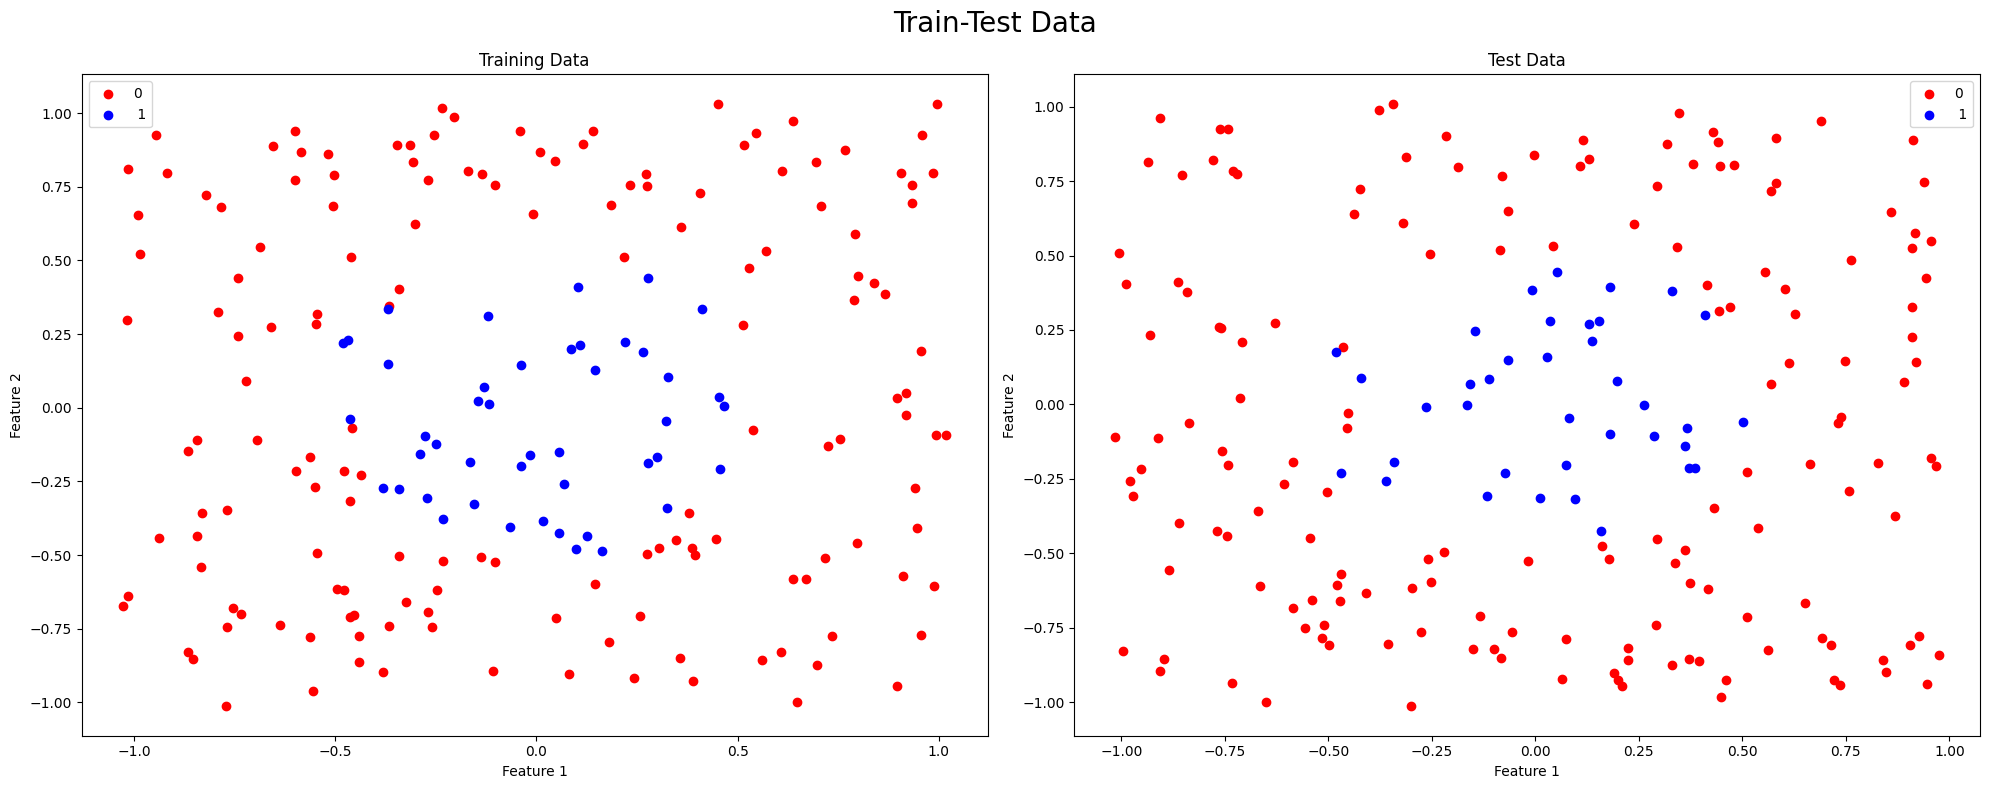

In [340]:
numpyNN.plot_train_test_data(x_train, y_train, x_test, y_test, 'circle-no_embedding')

In [341]:
third_feature_train = np.sum(x_train**2, axis=1)
x_train_augmented = np.concatenate((x_train, third_feature_train[:, np.newaxis]), axis=1)

third_feature_test = np.sum(x_test**2, axis=1)
x_test_augmented = np.concatenate((x_test, third_feature_test[:, np.newaxis]), axis=1)

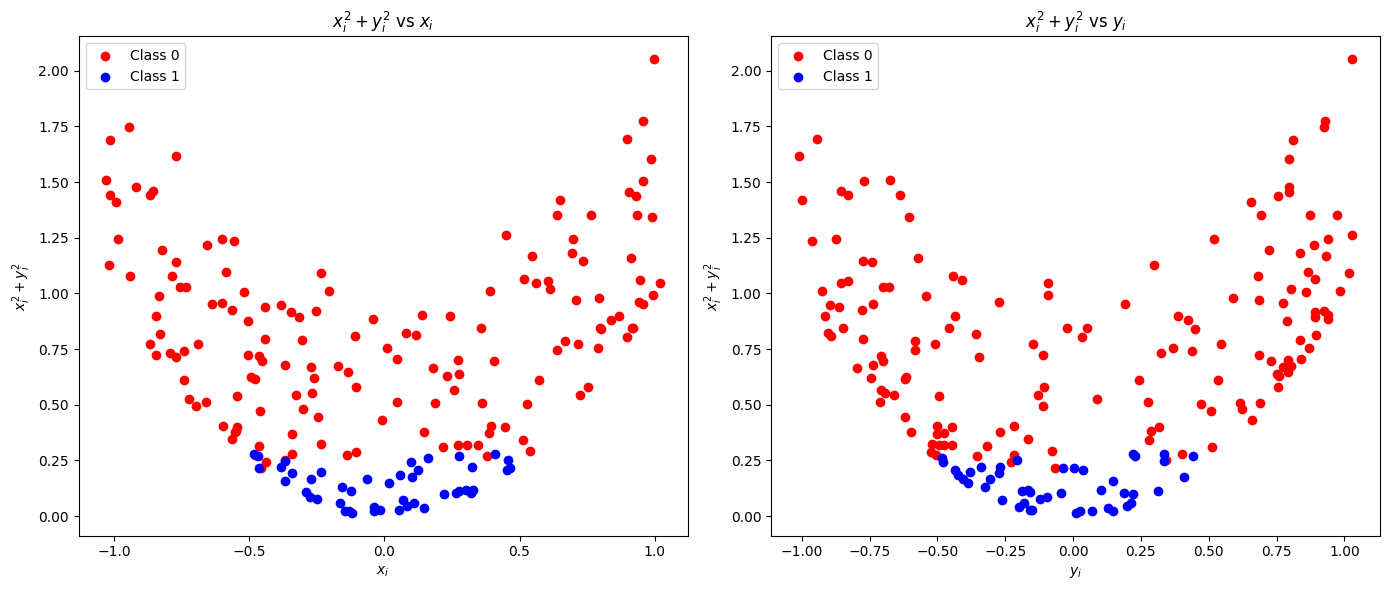

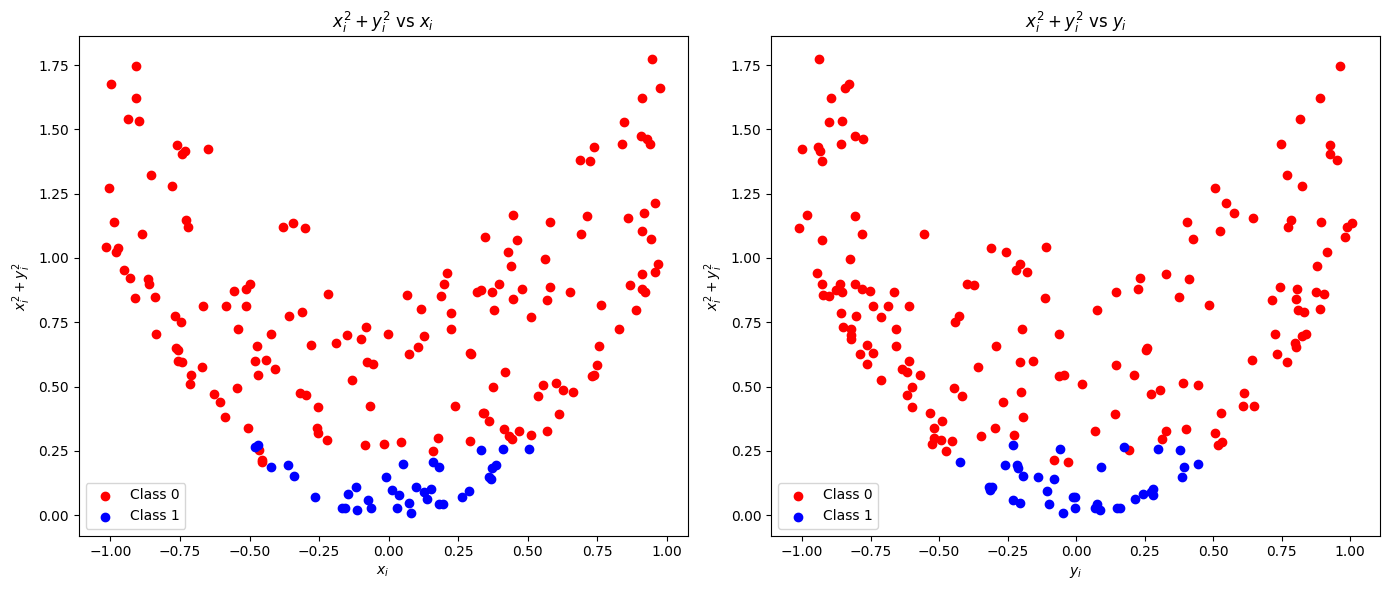

In [342]:
# plt.scatter(x_train_augmented[:, 0], x_train_augmented[:, 2], c=y_train.flatten())
plot_3d(x_train_augmented, y_train, 'x_{i}^2 + y_i^2')
plot_3d(x_test_augmented,y_test,  'x_{i}^2 + y_i^2')

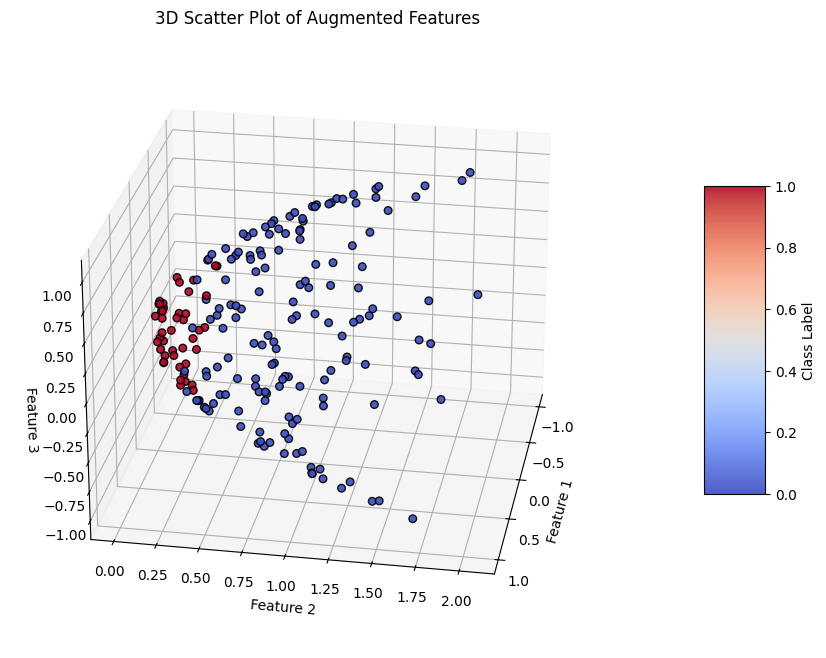

In [354]:
feature_1 = x_train_augmented[:, 0]
feature_2 = x_train_augmented[:, 1]
feature_3 = x_train_augmented[:, 2]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using feature_1, feature_2, feature_3 and coloring by y_train
scatter = ax.scatter(feature_1, feature_3, feature_2, c=y_train, cmap='coolwarm', edgecolors='k', s=30, alpha=0.9, marker='o')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Augmented Features')
ax.view_init(elev=25, azim=10, vertical_axis='z')

# Adding a color bar to interpret the colors
fig.colorbar(scatter, shrink=0.5, aspect=5, label='Class Label')

In [357]:
dim_in, dim_out = 3, 2
hidden_neuron_list = [1]
activation_list = ['ReLU', 'Sigmoid']
opt_init = 'xavier'
opt_loss = L2Loss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = Adam(mlp)
print(mlp.summary())

Model Summary
-------------
Layer 1: Linear - A Dim: 3, Output Dim: 1, Parameters: 4
Layer 2: ReLU
Layer 3: Linear - A Dim: 1, Output Dim: 2, Parameters: 4
Layer 4: Sigmoid
Total Parameters: 8
None


In [358]:
circle_embedded_logs = train_and_test_mlp(mlp, x_train_augmented, y_train, x_test_augmented, y_test, opt_loss, opt_optim, num_epoch=1000)

Epoch: 0, Train Loss: 0.24904960897632966, Train Accuracy: 0.8392857142857143, Test Loss: 0.24884537644937998, Test Accuracy: 0.815
Epoch: 1, Train Loss: 0.24811987007627923, Train Accuracy: 0.8392857142857143, Test Loss: 0.24776219534319388, Test Accuracy: 0.825
Epoch: 2, Train Loss: 0.2474790650753612, Train Accuracy: 0.8258928571428571, Test Loss: 0.24669706613187425, Test Accuracy: 0.825
Epoch: 3, Train Loss: 0.24625870235005548, Train Accuracy: 0.8392857142857143, Test Loss: 0.2457207515259126, Test Accuracy: 0.825
Epoch: 4, Train Loss: 0.24535614243732548, Train Accuracy: 0.8303571428571429, Test Loss: 0.2446977681512018, Test Accuracy: 0.815
Epoch: 5, Train Loss: 0.2448025700454878, Train Accuracy: 0.7991071428571429, Test Loss: 0.24366389441806433, Test Accuracy: 0.825
Epoch: 6, Train Loss: 0.24378559393597282, Train Accuracy: 0.7901785714285714, Test Loss: 0.24266205710083852, Test Accuracy: 0.82
Epoch: 7, Train Loss: 0.2422375225609374, Train Accuracy: 0.8035714285714286, Tes

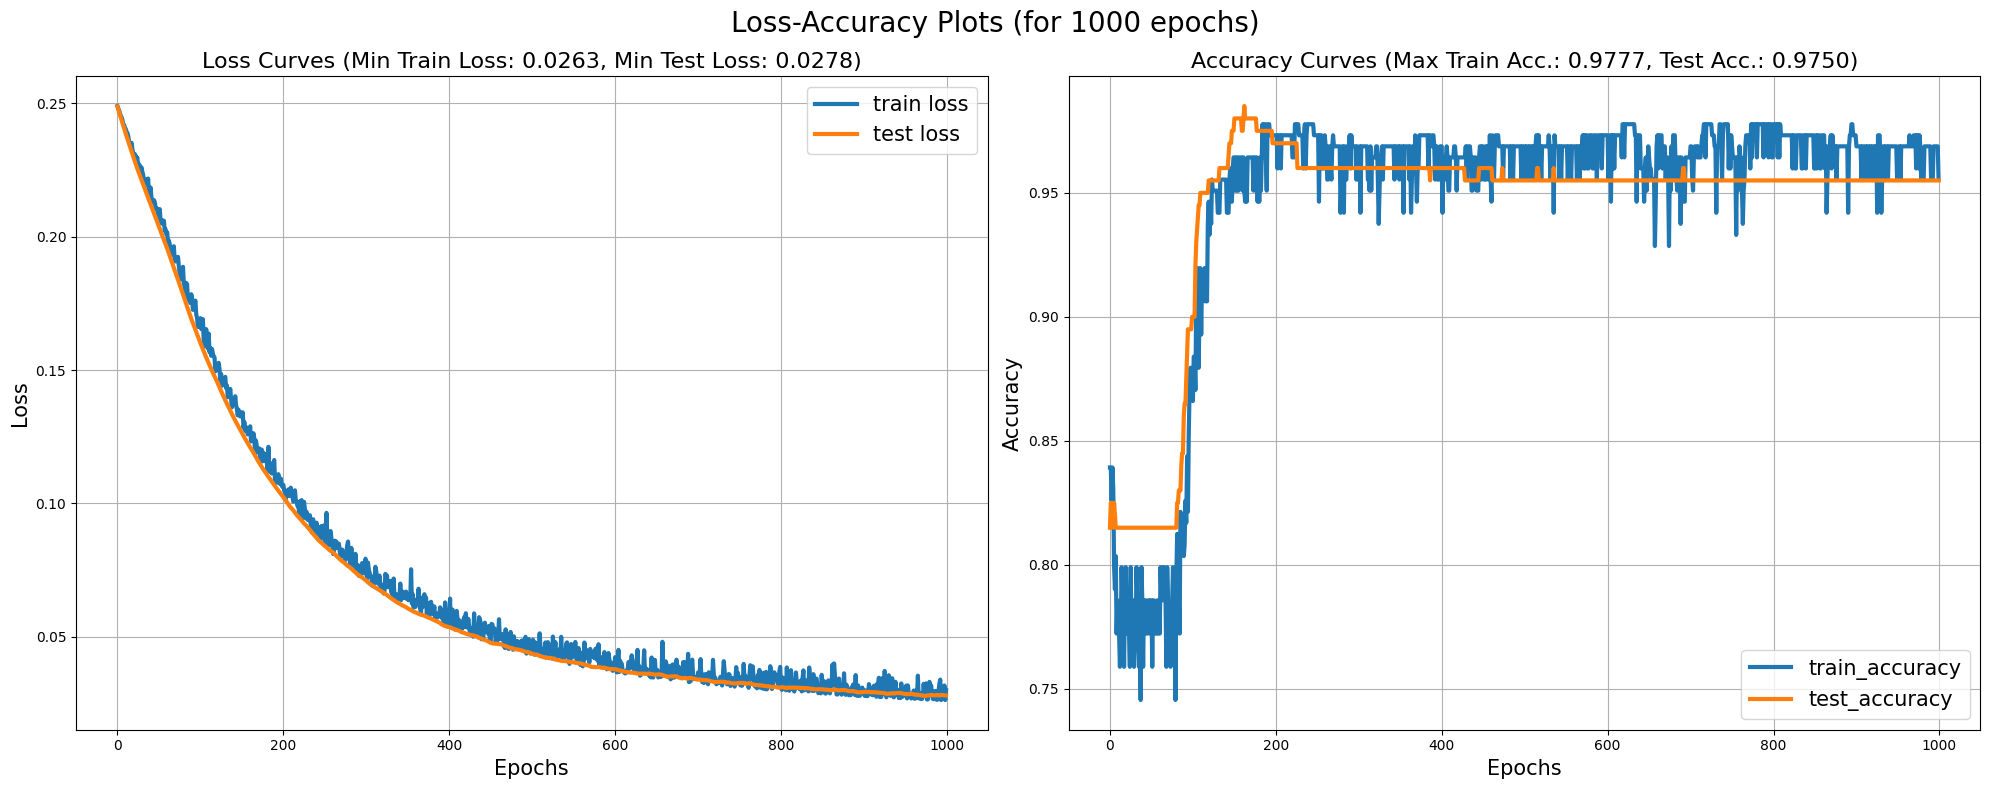

In [359]:
epochs = len(circle_embedded_logs['train_loss'])
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
numpyNN.plot_loss(circle_embedded_logs)
plt.subplot(1, 2, 2)
numpyNN.plot_accuracy(circle_embedded_logs)
plt.suptitle(f'Loss-Accuracy Plots (for {epochs} epochs)', fontsize=20)
plt.tight_layout()

In [360]:
def predict(X, model): # added this to work with my mlp
        y_pred = model.forward(X)
        return np.argmax(y_pred, axis=1)

In [204]:
# np.argmax(mlp.forward(x_test_augmented), axis=1)

In [218]:

X = x_test_augmented
y = y_test
savefig = False
name = None 

feature_1 = X[:, 0]
feature_2 = X[:, 1]
feature_3 = X[:, 2]

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1


xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=50),
                        np.linspace(y_min, y_max, num=50))

Z_feature = np.square(xx.ravel()) + np.square(yy.ravel())

X_augmented = np.c_[xx.ravel(), yy.ravel(), Z_feature]

Z_pred =  predict(X_augmented, model=mlp)
Z_pred_reshaped = Z_pred.reshape(xx.shape)
predicted_labels = np.argmax(mlp.forward(X), axis=1)


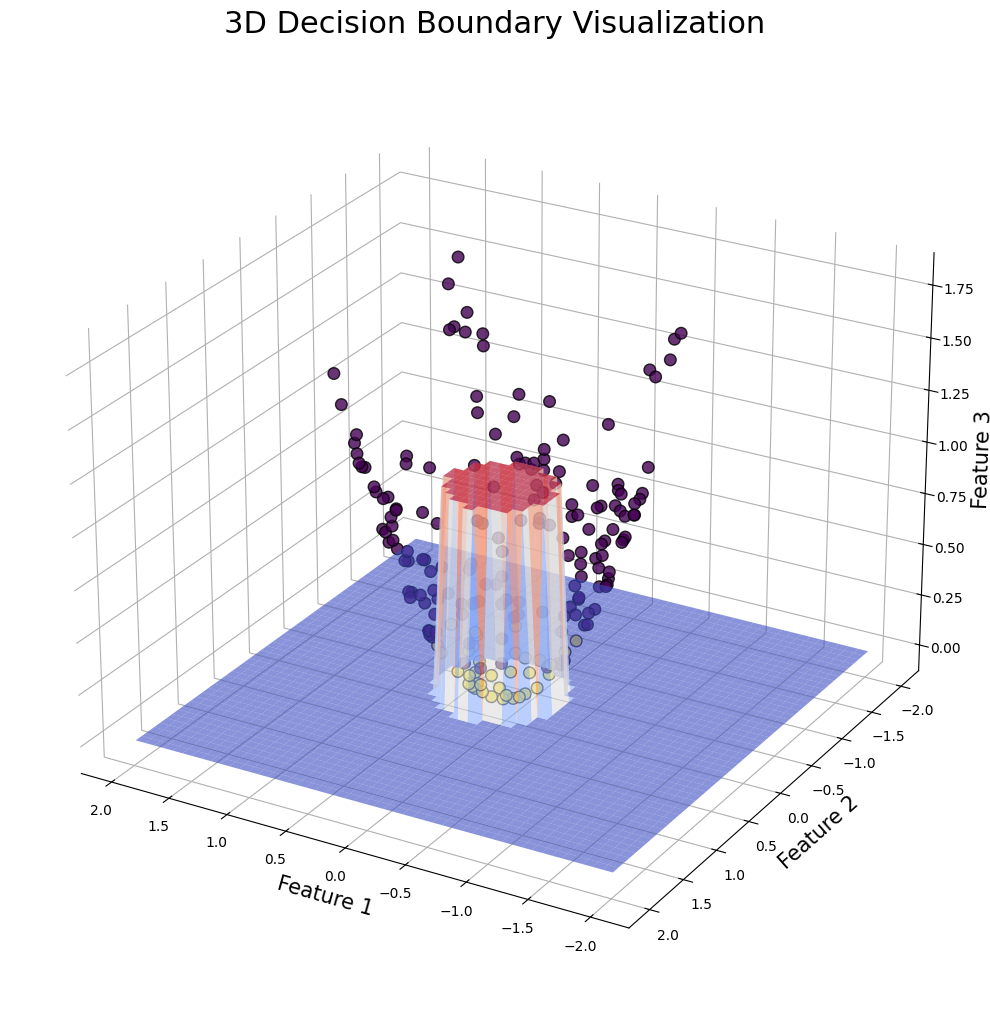

In [232]:
fig = plt.figure(figsize=(20, 10))

# Plot for predicted decision boundary using plot_surface
ax2 = fig.add_subplot(122, projection='3d')
surface = ax2.plot_surface(xx, yy, Z_pred_reshaped, cmap='coolwarm', edgecolor='none', alpha=0.6)
scatter = ax2.scatter(feature_1, feature_2, feature_3, c=y, cmap='viridis', edgecolors='k', s=70, alpha=0.8, marker='o', depthshade=True)
ax2.set_title('Predicted Decision Boundary', fontsize=18)
ax2.set_xlabel('Feature 1', fontsize=15)
ax2.set_ylabel('Feature 2', fontsize=15)
ax2.set_zlabel('Feature 3', fontsize=15)

# Change the background color of the plot
ax2.xaxis.pane.fill = False  # Remove the grid panes
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False
ax2.xaxis.pane.set_edgecolor('w')
ax2.yaxis.pane.set_edgecolor('w')
ax2.zaxis.pane.set_edgecolor('w')

ax2.tick_params(axis='both', which='major', labelsize=10)

# Adjust the view angle for better visibility and effect
ax2.view_init(elev=25, azim=120)

plt.title('3D Decision Boundary Visualization', fontsize=22)
plt.tight_layout()

if savefig and name:
    plt.savefig(name + 'boundary_3d.png')

plt.show()

# XOR

In [363]:
x_train, y_train, x_test, y_test = numpyNN.sample_data(data_name = 'XOR',nTrain=200, nTest=200)

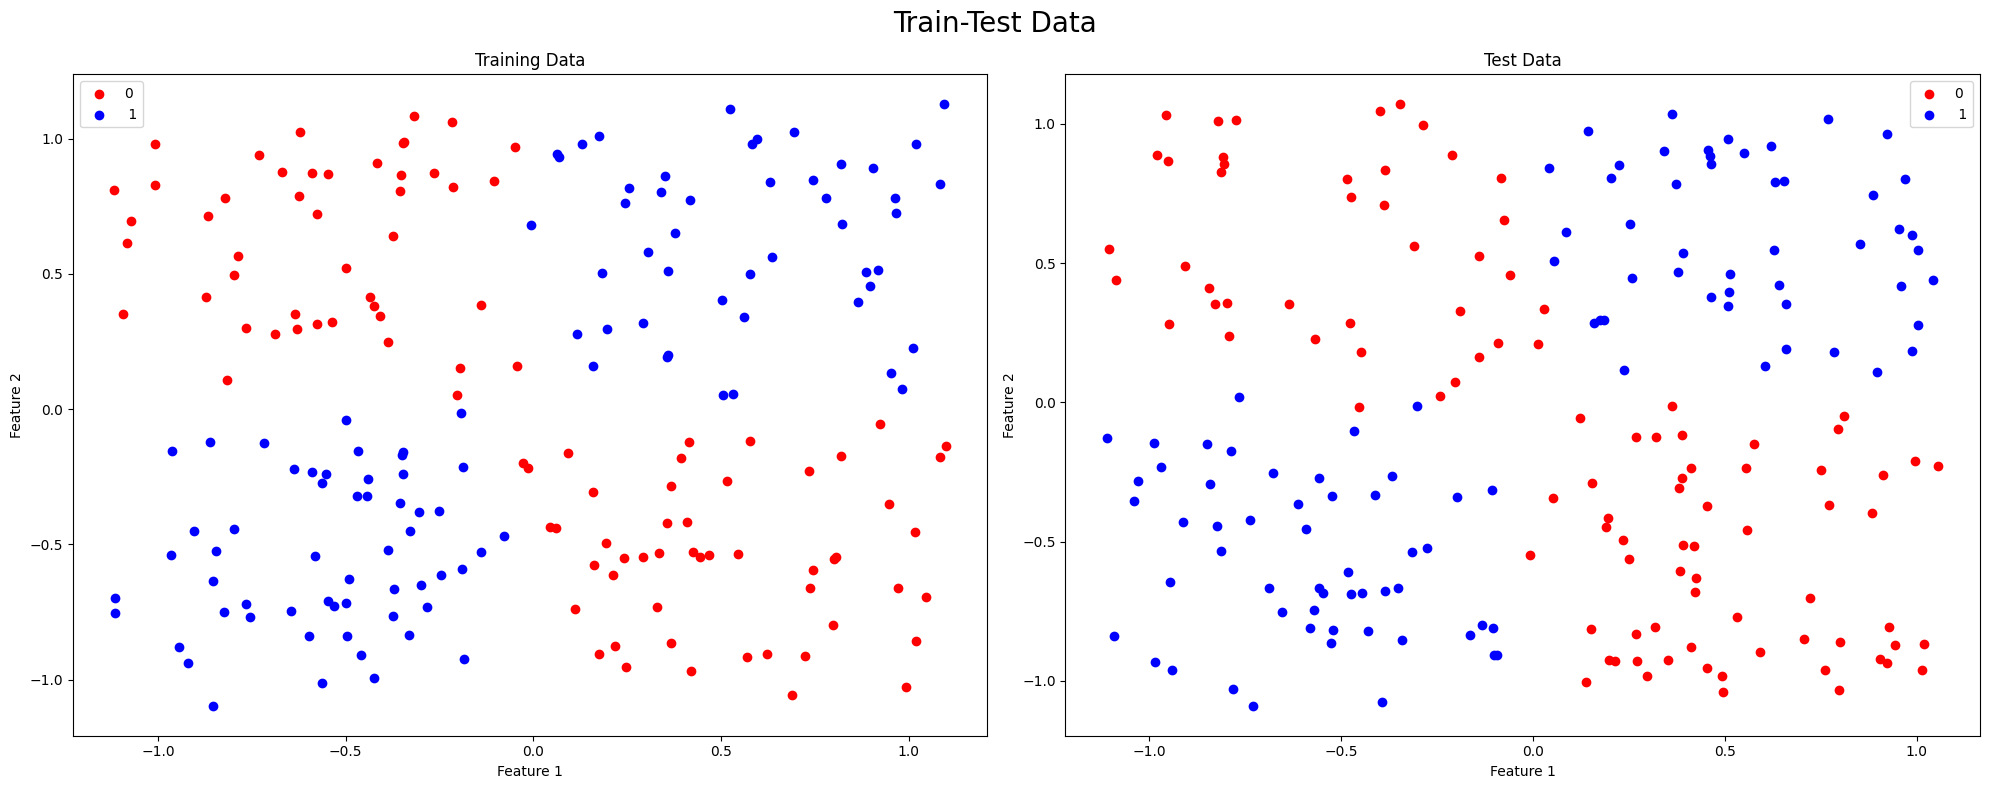

In [364]:
numpyNN.plot_train_test_data(x_train, y_train, x_test, y_test, 'XOR')

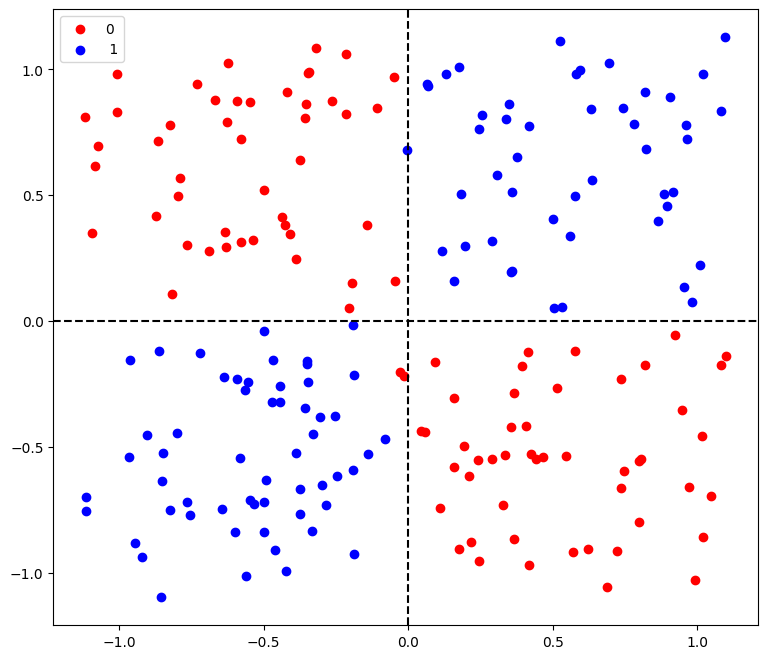

In [365]:
# Now, separate x_train data points
x_train_0 = x_train[y_train.flatten() == 0]
x_train_1 = x_train[y_train.flatten() == 1]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.scatter(x_train_0[:, 0], x_train_0[:, 1], c='red', label='0')
plt.scatter(x_train_1[:, 0], x_train_1[:, 1], c='blue', label=' 1')
plt.legend()
# vertical line at 0
plt.axvline(x=0, color='k', linestyle='--')
# horizontal line at 0
plt.axhline(y=0, color='k', linestyle='--')

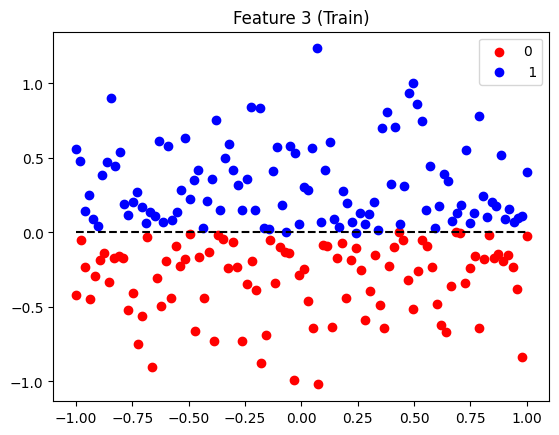

In [366]:
feature_3 = x_train[:, 0] * x_train[:, 1]
feature_3_0 = feature_3[y_train.flatten() == 0]
feature_3_1 = feature_3[y_train.flatten() == 1]

plt.scatter(np.linspace(-1, 1, num=len(feature_3_0))
, feature_3_0, c='red', label='0')

plt.scatter(np.linspace(-1, 1, num=len(feature_3_1))
,feature_3_1, c='blue', label=' 1')
plt.hlines(y=0, xmin=-1, xmax=1, color='k', linestyle='--')
plt.title('Feature 3 (Train)')
plt.legend()

In [368]:
non_linear_feature_train = (x_train[:, 0] * x_train[:, 1]).reshape(-1, 1)
non_linear_feature_test = (x_test[:, 0] * x_test[:, 1]).reshape(-1, 1)

In [369]:
x_train_augmented = np.hstack((x_train, non_linear_feature_train))
x_train_augmented[:,2][1:10], y_train[1:10]

(array([-0.0540169 , -0.2314343 ,  0.56241521,  0.47998971, -0.44629092,
        -0.29206042, -0.18207461,  0.14197706, -0.14057964]),
 array([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]]))

In [370]:
x_test_augmented = np.hstack((x_test, non_linear_feature_test))
x_test_augmented[:,2][1:10], y_test[1:10]

(array([ 0.00827138,  0.27720236,  0.17687866,  0.14339929,  0.42736285,
        -0.02735833,  0.00351259, -0.09761694,  0.91671124]),
 array([[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.]]))

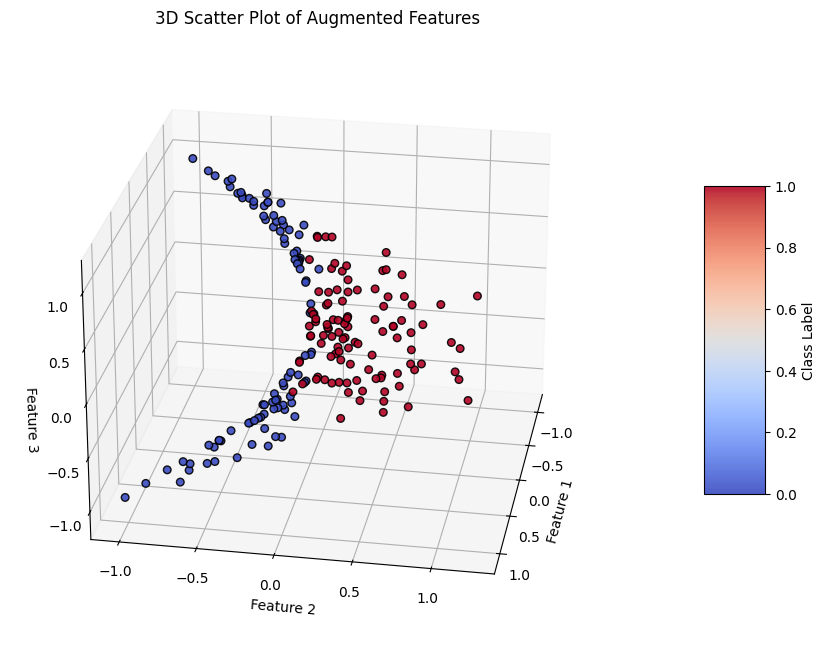

In [371]:
feature_1 = x_train_augmented[:, 0]
feature_2 = x_train_augmented[:, 1]
feature_3 = x_train_augmented[:, 2]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using feature_1, feature_2, feature_3 and coloring by y_train
scatter = ax.scatter(feature_1, feature_3, feature_2, c=y_train, cmap='coolwarm', edgecolors='k', s=30, alpha=0.9, marker='o')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Augmented Features')
ax.view_init(elev=25, azim=10, vertical_axis='z')

# Adding a color bar to interpret the colors
fig.colorbar(scatter, shrink=0.5, aspect=5, label='Class Label')

In [372]:
dim_in, dim_out = 3, 2
hidden_neuron_list = [1]
activation_list = ['ReLU', 'Sigmoid']
opt_init = 'xavier'
opt_loss = L2Loss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = Adam(mlp)
print(mlp.summary())

Model Summary
-------------
Layer 1: Linear - A Dim: 3, Output Dim: 1, Parameters: 4
Layer 2: ReLU
Layer 3: Linear - A Dim: 1, Output Dim: 2, Parameters: 4
Layer 4: Sigmoid
Total Parameters: 8
None


In [373]:
xor_embedded_logs = train_and_test_mlp(mlp, x_train_augmented, y_train, x_test_augmented, y_test, opt_loss, opt_optim, num_epoch=1000)

Epoch: 0, Train Loss: 0.2504903374710828, Train Accuracy: 0.42857142857142855, Test Loss: 0.2486060241264786, Test Accuracy: 0.485
Epoch: 1, Train Loss: 0.2500525780729384, Train Accuracy: 0.4419642857142857, Test Loss: 0.24821472713908097, Test Accuracy: 0.49
Epoch: 2, Train Loss: 0.24888286202676022, Train Accuracy: 0.48214285714285715, Test Loss: 0.2478465204002338, Test Accuracy: 0.5
Epoch: 3, Train Loss: 0.24947273168831435, Train Accuracy: 0.48214285714285715, Test Loss: 0.2474910030956644, Test Accuracy: 0.51
Epoch: 4, Train Loss: 0.24855107562149215, Train Accuracy: 0.49107142857142855, Test Loss: 0.2471394622828302, Test Accuracy: 0.525
Epoch: 5, Train Loss: 0.24829025249394315, Train Accuracy: 0.5044642857142857, Test Loss: 0.2468021609193081, Test Accuracy: 0.535
Epoch: 6, Train Loss: 0.24703984813253227, Train Accuracy: 0.5357142857142857, Test Loss: 0.24647218385952094, Test Accuracy: 0.54
Epoch: 7, Train Loss: 0.2472759782812106, Train Accuracy: 0.5267857142857143, Test L

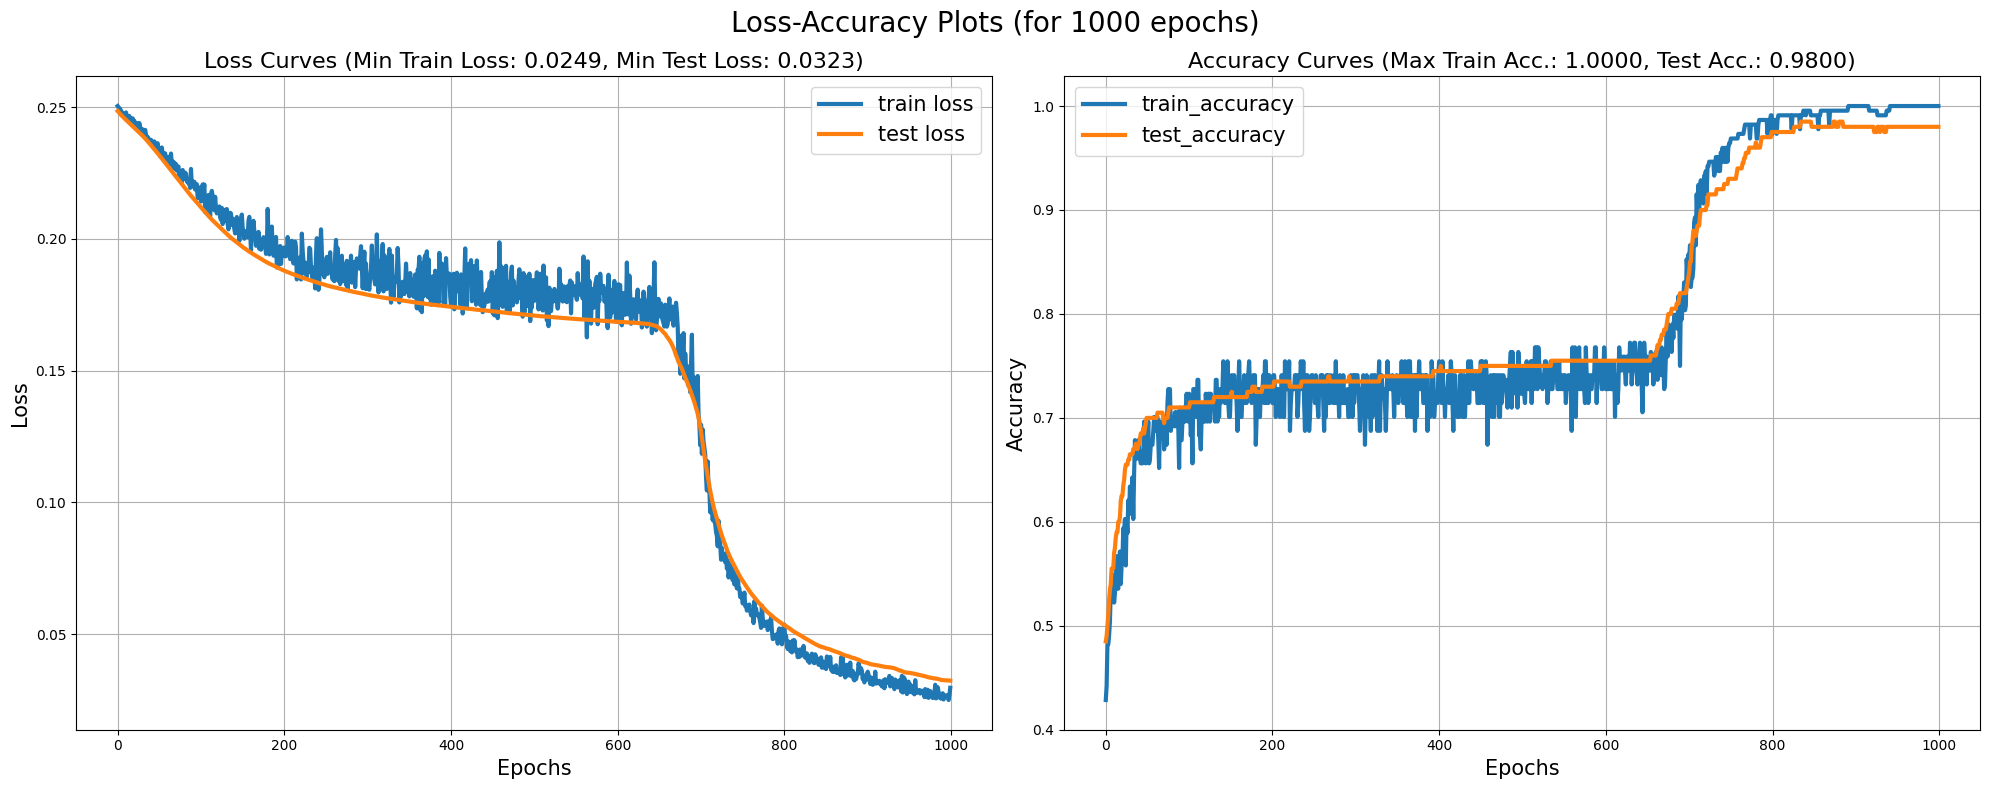

In [375]:
epochs = len(xor_embedded_logs['train_loss'])
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
numpyNN.plot_loss(xor_embedded_logs)
plt.subplot(1, 2, 2)
numpyNN.plot_accuracy(xor_embedded_logs)
plt.suptitle(f'Loss-Accuracy Plots (for {epochs} epochs)', fontsize=20)
plt.savefig('xor-embedding-train-loss.png')
plt.tight_layout()

In [378]:
X = x_test_augmented
y = y_test
savefig = False
name = None 

feature_1 = X[:, 0]
feature_2 = X[:, 1]
feature_3 = X[:, 2]

# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=50), np.linspace(y_min, y_max, num=50))

# # Predict the class labels using the model for the actual data points
# Z_pred = predict(X, model=mlp)

# # Reshape Z_pred for consistency with xx and yy if necessary
# # Note: This step might not be necessary if your predict() function already outputs the correct shape
# Z_pred_reshaped = Z_pred.reshape(xx.shape)

In [441]:
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=50), np.linspace(y_min, y_max, num=50))

# Flatten the grid to pass into predict function
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# Compute the non-linear feature for the grid
non_linear_feature_grid = grid_points[:, 0] * grid_points[:, 1]

# Combine the original grid features with the non-linear feature
X_grid_augmented = np.c_[grid_points, non_linear_feature_grid]

# Predict the class labels using the model for the grid
Z_pred_grid = predict(X_grid_augmented, model=mlp)

# Reshape Z_pred_grid to match the shape of xx and yy
Z_pred_reshaped = Z_pred_grid.reshape(xx.shape)

Text(0.5, 0, 'Feature 3')

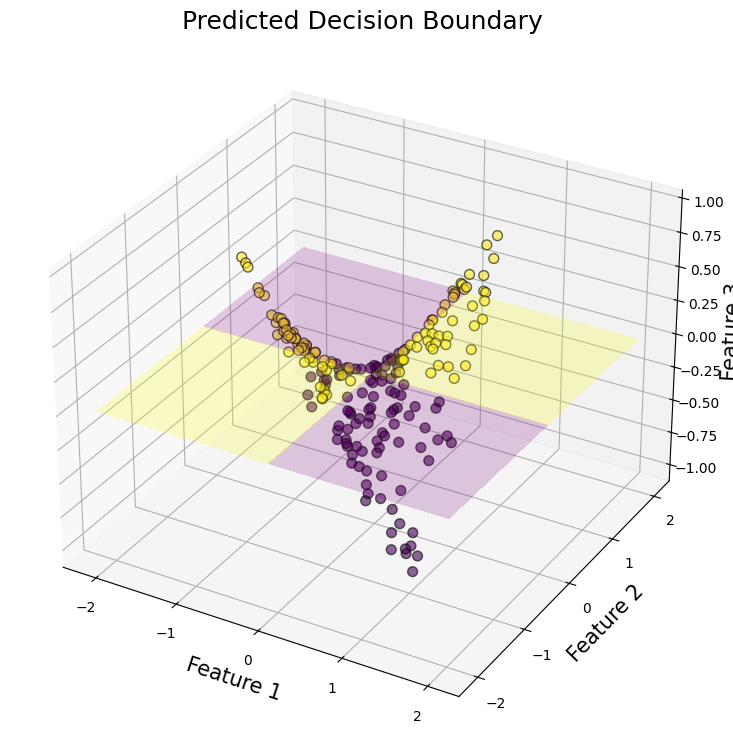

In [464]:
fig = plt.figure(figsize=(20, 10))
ax2 = fig.add_subplot(122, projection='3d')

# Plot the decision boundary as a hyperplane at the level where the model predicts 0.5
# You may need to adjust the levels based on your model's output
boundary_level = 0  # This is the decision threshold
ax2.contourf(xx, yy, Z_pred_reshaped, levels = 1, colors=['purple', 'yellow'], alpha=0.2, offset=0)

# Scatter plot of actual data points colored by their true labels
scatter = ax2.scatter(feature_1, feature_2, feature_3, c=y, cmap='viridis', edgecolors='k', s=50, alpha=0.6, marker='o')

ax2.set_title('Predicted Decision Boundary', fontsize=18)
ax2.set_xlabel('Feature 1', fontsize=15)
ax2.set_ylabel('Feature 2', fontsize=15)
ax2.set_zlabel('Feature 3', fontsize=15)

# ax2.view_init(elev=10, azim=120, vertical_axis='z')


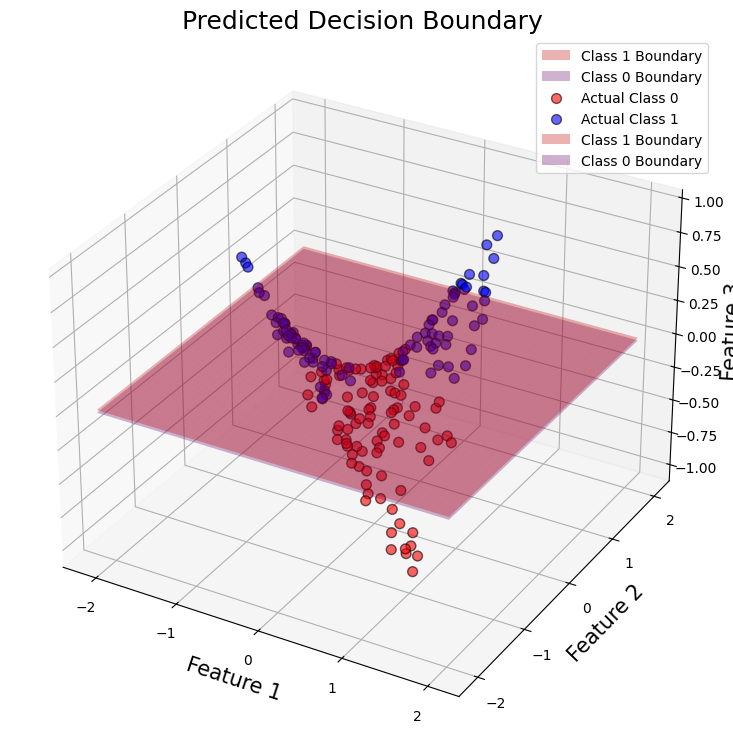

In [435]:
fig = plt.figure(figsize=(20, 10))

# Plot for predicted decision boundary using plot_surface
ax2 = fig.add_subplot(122, projection='3d')

# Define the decision threshold level
boundary_level = 0. # This is a typical decision threshold for binary classification
# Create two offset levels to represent the boundary for both classes
offset = 0.01  # Adjust the offset if needed to avoid z-fighting
upper_boundary = boundary_level + offset
lower_boundary = boundary_level - offset

# Plot the upper boundary surface
upper_surface = ax2.plot_surface(xx, yy, Z_pred_reshaped * 0 + upper_boundary, color='red', edgecolor='none', alpha=0.3, label='Class 1 Boundary')

# Plot the lower boundary surface
lower_surface = ax2.plot_surface(xx, yy, Z_pred_reshaped * 0 + lower_boundary, color='purple', edgecolor='none', alpha=0.3, label='Class 0 Boundary')

# Scatter plot of actual data points colored by their true labels
class_0_scatter = ax2.scatter(feature_1[y.flatten() == 0], feature_2[y.flatten() == 0], feature_3[y.flatten() == 0], c='red', edgecolors='k', s=50, alpha=0.6, marker='o', label='Actual Class 0')
class_1_scatter = ax2.scatter(feature_1[y.flatten() == 1], feature_2[y.flatten() == 1], feature_3[y.flatten() == 1], c='blue', edgecolors='k', s=50, alpha=0.6, marker='o', label='Actual Class 1')

ax2.set_title('Predicted Decision Boundary', fontsize=18)
ax2.set_xlabel('Feature 1', fontsize=15)
ax2.set_ylabel('Feature 2', fontsize=15)
ax2.set_zlabel('Feature 3', fontsize=15)

# Manually create a legend for the boundary
handles, labels = ax2.get_legend_handles_labels()
handles.append(upper_surface)
labels.append('Class 1 Boundary')
handles.append(lower_surface)
labels.append('Class 0 Boundary')
ax2.legend(handles, labels, loc='best')

plt.show()


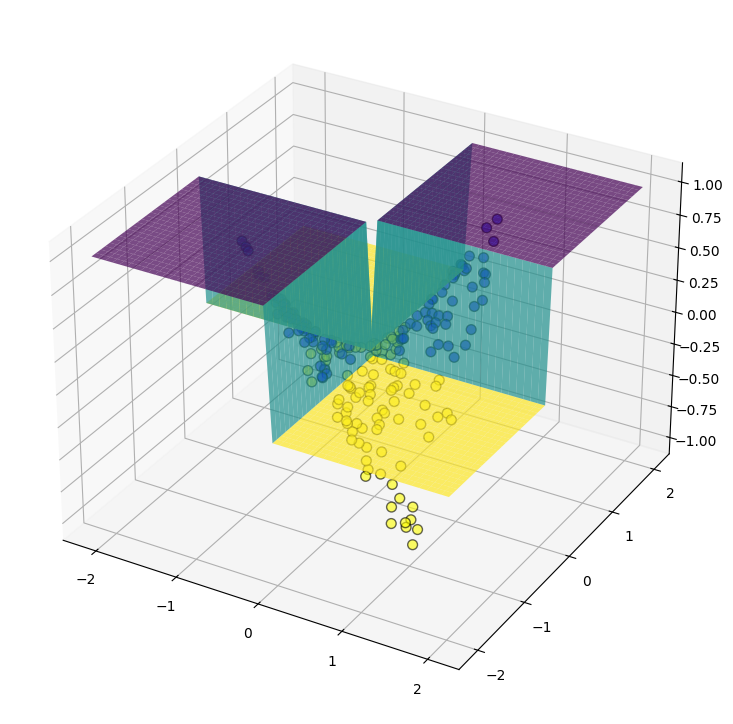

In [411]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(xx, yy, Z_pred_reshaped, alpha=0.7, cmap='viridis_r')
# Scatter plot of actual data points colored by their true labels
class_0_scatter = ax.scatter(feature_1[y.flatten() == 0], feature_2[y.flatten() == 0], feature_3[y.flatten() == 0], c='yellow', edgecolors='k', s=50, alpha=0.6, marker='o', label='Actual Class 0')
class_1_scatter = ax.scatter(feature_1[y.flatten() == 1], feature_2[y.flatten() == 1], feature_3[y.flatten() == 1], c='blue', edgecolors='k', s=50, alpha=0.6, marker='o', label='Actual Class 1')

Text(0.5, 0, 'Feature 3')

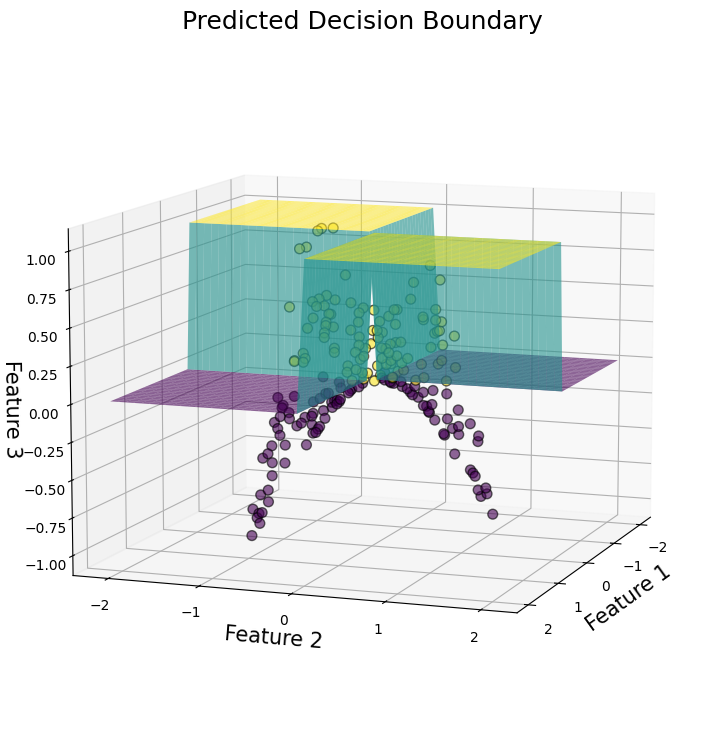

In [434]:
fig = plt.figure(figsize=(20, 10))

# Plot for predicted decision boundary using plot_surface
ax2 = fig.add_subplot(122, projection='3d')
# Plot the decision boundary using Z_pred_reshaped
surface = ax2.plot_surface(xx, yy, Z_pred_reshaped, cmap='viridis', edgecolor='none', alpha=0.6, vmin=0, vmax=1)
# Scatter plot of actual data points colored by their true labels
scatter = ax2.scatter(feature_1, feature_2, feature_3, c=y, cmap='viridis', edgecolors='k', s=50, alpha=0.6, marker='o')

ax2.view_init(elev=10, azim=20, vertical_axis='z')


ax2.set_title('Predicted Decision Boundary', fontsize=18)
ax2.set_xlabel('Feature 1', fontsize=15)
ax2.set_ylabel('Feature 2', fontsize=15)
ax2.set_zlabel('Feature 3', fontsize=15)

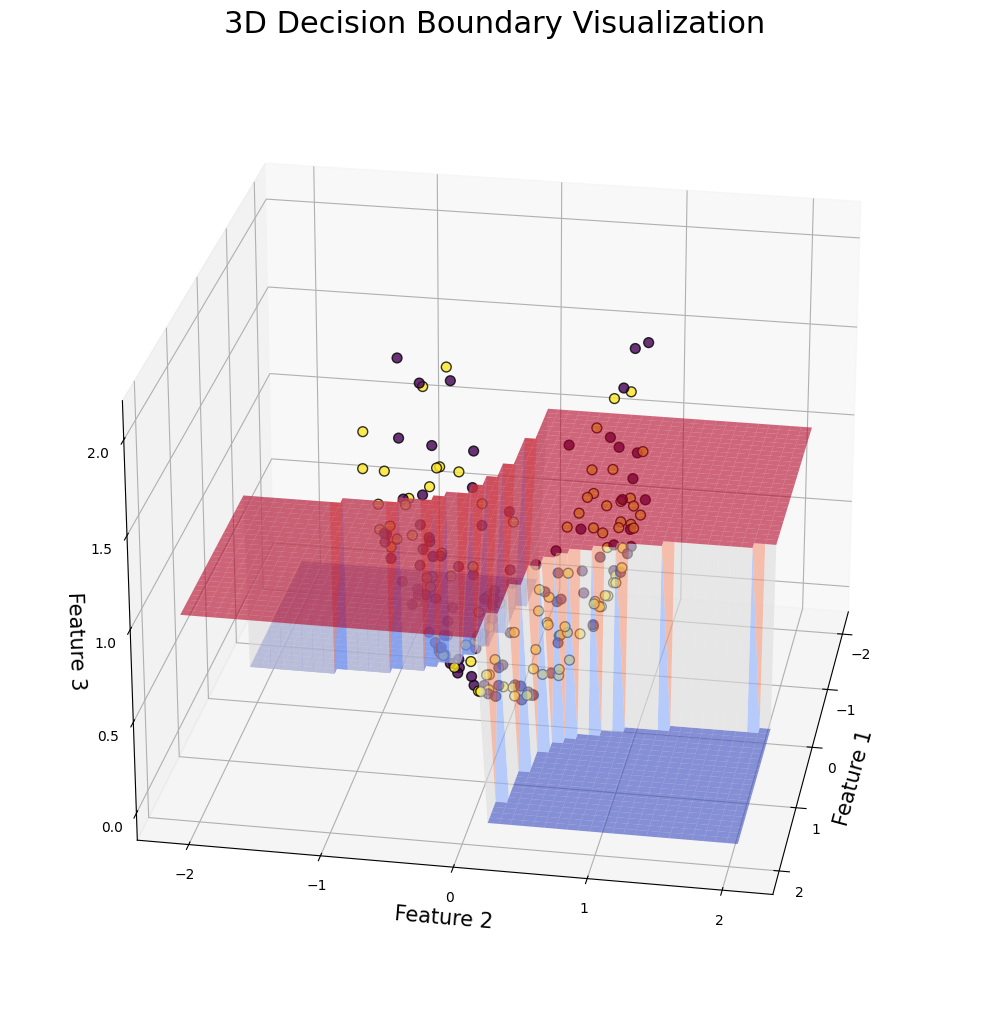

In [362]:
# Assuming mlp is a trained model

# Create a meshgrid covering the feature space
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=50), np.linspace(y_min, y_max, num=50))

# Flatten the grid to pass into predict function
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Compute the non-linear feature for the grid
non_linear_feature_grid = grid_points[:, 0] * grid_points[:, 1]

# Combine the original grid features with the non-linear feature
X_grid_augmented = np.c_[grid_points, non_linear_feature_grid]

# Predict the class labels using the model for the grid
Z_pred_grid = predict(X_grid_augmented, model=mlp)

# Reshape Z_pred_grid to match the shape of xx and yy
Z_pred_reshaped = Z_pred_grid.reshape(xx.shape)

fig = plt.figure(figsize=(20, 10))

# Plot for predicted decision boundary using plot_surface
ax2 = fig.add_subplot(122, projection='3d')
# Plot the decision boundary using Z_pred_reshaped
surface = ax2.plot_surface(xx, yy, Z_pred_reshaped, cmap='coolwarm', edgecolor='none', alpha=0.6)
# Scatter plot of actual data points colored by their true labels
scatter = ax2.scatter(feature_1, feature_2, feature_3, c=y, cmap='viridis', edgecolors='k', s=50, alpha=0.8, marker='o')

ax2.set_title('Predicted Decision Boundary', fontsize=18)
ax2.set_xlabel('Feature 1', fontsize=15)
ax2.set_ylabel('Feature 2', fontsize=15)
ax2.set_zlabel('Feature 3', fontsize=15)
ax2.view_init(elev=25, azim=10, vertical_axis='z')

# Adjust the view angle for better visibility and effect
ax2.view_init(elev=25, azim=10)

plt.title('3D Decision Boundary Visualization', fontsize=22)
plt.tight_layout()

if savefig and name:
    plt.savefig(name + 'boundary_3d.png')

plt.show()

In [ ]:

# X = x_train_augmented
# y = y_train
# savefig = False
# name = None 

# feature_1 = X[:, 0]
# feature_2 = X[:, 1]
# feature_3 = X[:, 2]

# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1


# xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=50),
#                         np.linspace(y_min, y_max, num=50))

# Z_feature = np.square(xx.ravel()) + np.square(yy.ravel())

# X_augmented = np.c_[xx.ravel(), yy.ravel(), Z_feature]

# Z_pred =  predict(X_augmented, model=mlp)
# Z_pred_reshaped = Z_pred.reshape(xx.shape)
# predicted_labels = np.argmax(mlp.forward(X), axis=1)

# # Plot for actual labels
# fig = plt.figure(figsize=(20, 8))

# ax1 = fig.add_subplot(121, projection='3d')
# ax1.scatter(feature_1, feature_2, feature_3, c=y_train, cmap='coolwarm', edgecolors='k', s=30, alpha=0.9, marker='o', label='Actual Labels', depthshade=False)
# ax1.scatter(feature_1, feature_2, feature_3 , c=predicted_labels, cmap='viridis', edgecolors='k', s=30, alpha=0.9, marker='^', label='Predicted Labels', depthshade=False)

# ax1.set_title('Actual Labels')
# ax1.set_xlabel('Feature 1')
# ax1.set_ylabel('Feature 2')
# ax1.set_zlabel('Feature 3')
# ax1.legend()

# # Plot for predicted decision boundary using plot_surface
# ax2 = fig.add_subplot(122, projection='3d')
# surface = ax2.plot_surface(xx, yy, Z_pred_reshaped, cmap='coolwarm', edgecolor='none', alpha=0.4)
# ax2.scatter(feature_1, feature_2, feature_3, c=y_train, cmap='viridis', edgecolors='k', s=50, alpha=0.5, marker='o', depthshade=False)
# ax2.set_title('Predicted Decision Boundary')
# ax2.set_xlabel('Feature 1')
# ax2.set_ylabel('Feature 2')
# ax2.set_zlabel('Predicted Class')
    

# # fig = plt.figure(figsize=(20, 10))
# # ax1 = fig.add_subplot(121, projection='3d')

# # # Plotting predicted classes with one marker style
# # scatter1 = ax1.scatter(xx.ravel(), yy.ravel(), Z_feature, c=Z_pred, cmap='viridis', depthshade=False, alpha=0.1, marker='^', label='Predicted Labels')

# # # Plotting actual data points with another marker style
# # ax1.scatter(feature_1, feature_2, feature_3, c=y, cmap='coolwarm', edgecolors='k', s=30, alpha=0.9, marker='o', label='Actual Labels', depthshade=False)

# # ax1.set_xlabel('Feature 1')
# # ax1.set_ylabel('Feature 2')
# # ax1.set_zlabel('Predicted Class, Decision Boundary')
# # ax1.legend()

# plt.title('3D Decision Boundary Visualization')

# # Adjustments for the second subplot similar to the first, as needed
#     # Note: The actual implementation here will depend on the specifics of your dataset and prediction task

# if savefig and name:
#     plt.savefig(name + 'boundary_3d.png')

# plt.show()

# Swiss Roll

In [465]:
x_train, y_train, x_test, y_test = numpyNN.sample_data(data_name = 'swiss-roll',nTrain=200, nTest=200)

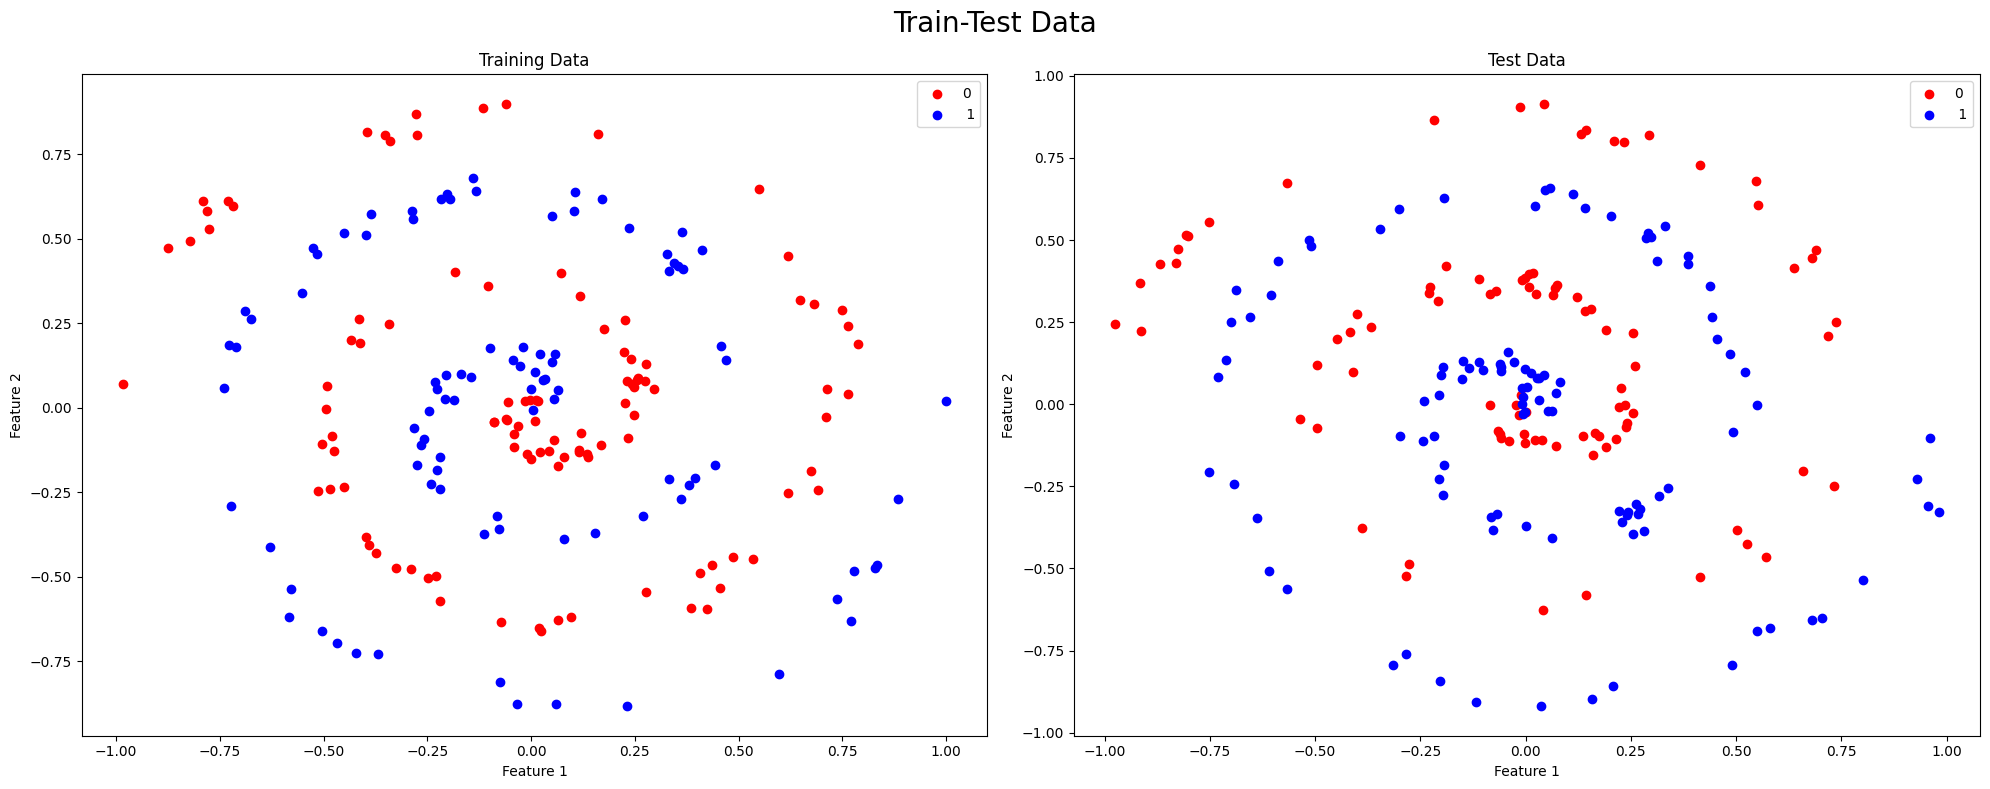

In [466]:
numpyNN.plot_train_test_data(x_train, y_train, x_test, y_test, 'XOR')

In [538]:
f1, f2 = x_train[:, 0], x_train[:, 1]
non_linear_feature_train_1 =  np.arctan(f2/f1)
# .reshape(-1, 1)
non_linear_feature_train_1 = non_linear_feature_train_1.reshape(-1, 1)
non_linear_feature_train_2 =  np.sin(f2) + np.cos(f1)
# .reshape(-1, 1)
non_linear_feature_train_2 = non_linear_feature_train_2.reshape(-1, 1)
# non_linear_feature_test = (x_test[:, 0] * x_test[:, 1])
# non_linear_feature_test= non_linear_feature_test.reshape(-1, 1)

In [539]:
f1, f2 = x_test[:, 0], x_test[:, 1]
non_linear_feature_test_1 = np.exp(-.7 * np.sqrt(f1**2 + f2**2))
# .reshape(-1, 1)
non_linear_feature_test_1 = non_linear_feature_test_1.reshape(-1, 1)
non_linear_feature_test_2 =  np.sum(x_test**2, axis=1)
# .reshape(-1, 1)
non_linear_feature_test_2 = non_linear_feature_test_2.reshape(-1, 1)

In [540]:
x_train_augmented = np.hstack((x_train, non_linear_feature_train_1, non_linear_feature_train_2))
x_train_augmented[1:10], y_train[1:10]

x_test_augmented = np.hstack((x_test, non_linear_feature_test_1, non_linear_feature_test_2))
x_test_augmented[1:10], y_test[1:10]

(array([[-0.31593899, -0.79372468,  0.5499076 ,  0.72981631],
        [ 0.07243256, -0.12759228,  0.9023951 ,  0.02152627],
        [-0.01518491, -0.03205108,  0.97547928,  0.00125785],
        [-0.14940314,  0.1332572 ,  0.86923845,  0.04007878],
        [-0.1969513 , -0.27644897,  0.78851633,  0.11521385],
        [-0.41779396,  0.2205866 ,  0.71840923,  0.22321024],
        [ 0.0728871 ,  0.03415894,  0.9452119 ,  0.00647936],
        [-0.5106879 ,  0.48231291,  0.61157912,  0.49342788],
        [ 0.92955961, -0.22692666,  0.51181071,  0.91557678]]),
 array([[1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.]]))

In [541]:
x_train_augmented.shape, x_test_augmented.shape


((200, 4), (200, 4))

In [542]:
dim_in, dim_out = 4, 2
hidden_neuron_list = [4]
activation_list = ['ReLU', 'Sigmoid']
opt_init = 'xavier'
opt_loss = L2Loss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = Adam(mlp)
print(mlp.summary())

Model Summary
-------------
Layer 1: Linear - A Dim: 4, Output Dim: 4, Parameters: 20
Layer 2: ReLU
Layer 3: Linear - A Dim: 4, Output Dim: 2, Parameters: 10
Layer 4: Sigmoid
Total Parameters: 30
None


In [543]:
spiral_embedded_logs = train_and_test_mlp(mlp, x_train_augmented, y_train, x_test_augmented, y_test, opt_loss, opt_optim, num_epoch=1000)

Epoch: 0, Train Loss: 0.2524109521735444, Train Accuracy: 0.45089285714285715, Test Loss: 0.2632996856910966, Test Accuracy: 0.535
Epoch: 1, Train Loss: 0.2463449017741685, Train Accuracy: 0.4642857142857143, Test Loss: 0.2626712773537323, Test Accuracy: 0.535
Epoch: 2, Train Loss: 0.2498213887255513, Train Accuracy: 0.4642857142857143, Test Loss: 0.2621783022638372, Test Accuracy: 0.535
Epoch: 3, Train Loss: 0.2511457501654517, Train Accuracy: 0.46875, Test Loss: 0.2615581897419684, Test Accuracy: 0.535
Epoch: 4, Train Loss: 0.2458031387609804, Train Accuracy: 0.5178571428571429, Test Loss: 0.26096940419854764, Test Accuracy: 0.535
Epoch: 5, Train Loss: 0.24944288269667855, Train Accuracy: 0.4955357142857143, Test Loss: 0.26056261217842625, Test Accuracy: 0.535
Epoch: 6, Train Loss: 0.2495067594466798, Train Accuracy: 0.46875, Test Loss: 0.26008198314482683, Test Accuracy: 0.535
Epoch: 7, Train Loss: 0.24341377447373613, Train Accuracy: 0.4955357142857143, Test Loss: 0.259725927656969

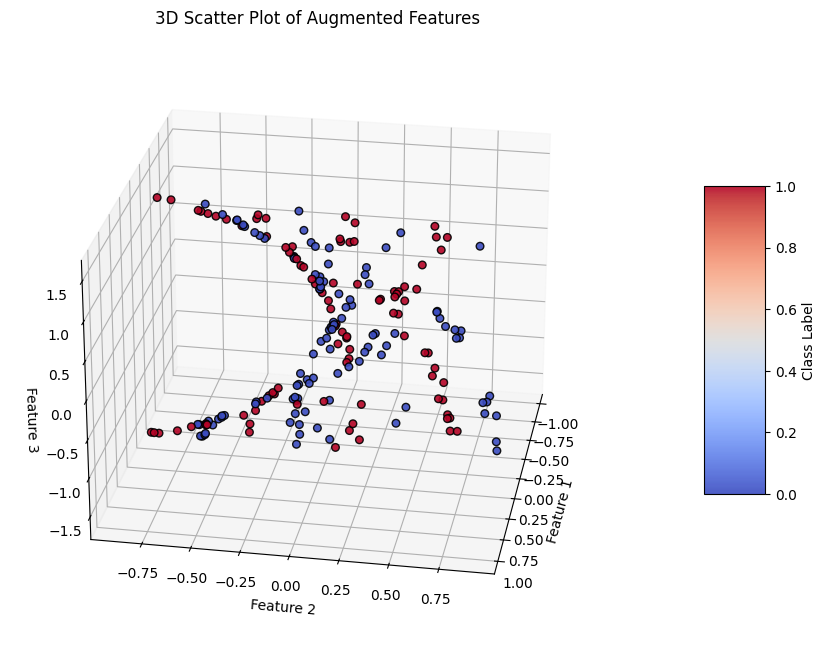

In [521]:
feature_1 = x_train_augmented[:, 0]
feature_2 = x_train_augmented[:, 1]
feature_3 = x_train_augmented[:, 2]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using feature_1, feature_2, feature_3 and coloring by y_train
scatter = ax.scatter(feature_1,feature_2,  feature_3, c=y_train, cmap='coolwarm', edgecolors='k', s=30, alpha=0.9, marker='o')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Augmented Features')
ax.view_init(elev=25, azim=10, vertical_axis='z')

# Adding a color bar to interpret the colors
fig.colorbar(scatter, shrink=0.5, aspect=5, label='Class Label')